In [1]:
import pandas as pd
import numpy as np
import psycopg2
import itertools
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
conn = psycopg2.connect("dbname='FSCCases_FVSOut_20170903' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.mgmtid, carbon.total_stand_carbon, hrv_carbon.products, 
    pnv, undiscounted_cost, undiscounted_revenue, discounted_cost, discounted_revenue, 
    mrch_cubic_volume, mrch_boardfoot_volume
FROM summary, cases, carbon, hrv_carbon, econsummary
WHERE summary.caseid = cases.caseid AND carbon.caseid = cases.caseid AND hrv_carbon.caseid = cases.caseid AND econsummary.caseid = cases.caseid
    AND summary.year = carbon.year AND summary.year = hrv_carbon.year AND summary.year = econsummary.year;
'''
# read the query into a pandas dataframe
FVSOut = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [4]:
FVSOut.head()

,caseid,standid,year,age,tpa,ba,sdi,ccf,topht,qmd,...,mgmtid,total_stand_carbon,products,pnv,undiscounted_cost,undiscounted_revenue,discounted_cost,discounted_revenue,mrch_cubic_volume,mrch_boardfoot_volume
0,22841503-18e6-4d02-8c60-6f176cd81b7c,10000,2014,83,243.0,443.0,640.0,486.0,113.0,18.30110,...,Rx5,49.0151,65.4402,43640.9,26897.8,74045.6,26878.7,70519.6,12722,106899
1,22841503-18e6-4d02-8c60-6f176cd81b7c,10000,2029,15,616.0,59.0,153.0,140.0,40.0,4.20046,...,Rx5,29.5300,31.5344,43544.7,27097.8,74045.6,26974.9,70519.6,0,0
2,237c4bf0-2a82-42dd-a051-40313b6eca2e,10001,2049,35,206.0,274.0,422.0,308.0,125.0,15.60870,...,Rx3,129.0560,15.9765,34023.5,20855.1,57493.5,20732.2,54755.7,0,0
3,237c4bf0-2a82-42dd-a051-40313b6eca2e,10001,2099,40,202.0,211.0,341.0,245.0,130.0,13.84660,...,Rx3,94.1591,17.6173,37424.3,40445.9,110019.0,22899.0,60323.2,0,0
4,42f52314-841b-4cfa-bc83-0d739012068b,10001,2049,118,132.0,523.0,648.0,514.0,155.0,26.96840,...,Rx1,268.9960,0.0000,0.0,0.0,0.0,0.0,0.0,0,0


In [5]:
FVSOut['allcarbon'] = FVSOut.total_stand_carbon + FVSOut.products
FVSOut['undiscounted_net'] = FVSOut.undiscounted_revenue - FVSOut.undiscounted_cost

### Inspect outputs by Rx (not adjusted by area of each property)

In [88]:
grouped_merchbdft = FVSOut[['mgmtid', 'standid', 'mrch_boardfoot_volume']].groupby(['mgmtid', 'standid']).sum() 
grouped_sumrbdft = FVSOut[['mgmtid', 'standid', 'rbdft']].groupby(['mgmtid', 'standid']).sum()
grouped_endbdft = FVSOut[['standid', 'mgmtid', 'bdft']].loc[FVSOut.year==2104].groupby(['mgmtid', 'standid']).sum()
grouped_avgcarbon = FVSOut[['mgmtid', 'standid', 'allcarbon']].groupby(['mgmtid', 'standid']).mean()
grouped_rev = FVSOut[['standid', 'mgmtid', 'undiscounted_net', 'pnv']].loc[FVSOut.year==2104].groupby(['mgmtid', 'standid']).sum()
regrouped = pd.concat([grouped_merchbdft, grouped_sumrbdft, grouped_endbdft, grouped_avgcarbon, grouped_rev], axis=1).sort_index()
regrouped.head()

mrch_boardfoot_volume  rbdft      bdft  allcarbon  \
mgmtid standid                                                      
Rx1    1                            0    0.0  146356.0  192.84786   
       10                           0    0.0  154255.0  216.02735   
       100                          0    0.0  151884.0  204.45730   
       1000                         0    0.0  161576.0  212.04450   
       10000                        0    0.0  256072.0  276.22340   

                undiscounted_net  pnv  
mgmtid standid                         
Rx1    1                     0.0  0.0  
       10                    0.0  0.0  
       100                   0.0  0.0  
       1000                  0.0  0.0  
       10000                 0.0  0.0

In [89]:
regrouped['tot_bdft'] = regrouped.rbdft + regrouped.bdft

In [90]:
baseline = regrouped.xs('Rx2', level='mgmtid', drop_level=True)
baseline.head()

,mrch_boardfoot_volume,rbdft,bdft,allcarbon,undiscounted_net,pnv,tot_bdft
standid,,,,,,,
1,127658,133758.0,59929.0,75.461637,45172.5,6025.41,193687.0
10,149183,152752.0,61379.0,87.860960,53816.7,12519.20,214131.0
100,146021,149727.0,60785.0,85.254185,52493.0,11624.30,210512.0
1000,142267,144879.0,2008.0,87.213270,52183.6,15255.90,146887.0
10000,191892,194211.0,44578.0,76.496275,76517.0,45220.90,238789.0


In [91]:
diff = regrouped - baseline

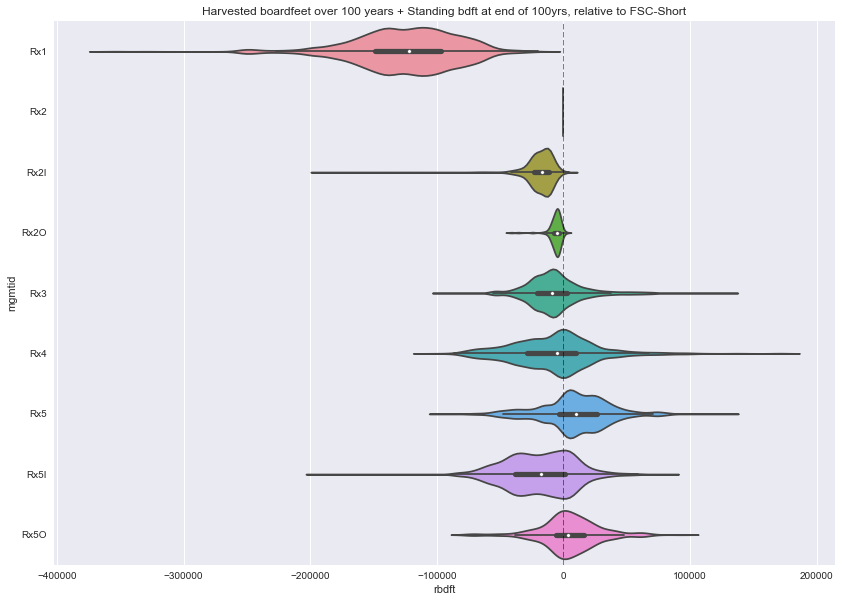

In [92]:
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.violinplot(y=diff.index.get_level_values(0), x=diff.rbdft, orient='h', split=True, scale='width')
ax.set_title('Harvested boardfeet over 100 years + Standing bdft at end of 100yrs, relative to FSC-Short')
#ax.set_xlim(-20000, 1000)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

### Get info about property ages and areas

In [14]:
conn = psycopg2.connect("dbname='FVSIn' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT stand_id as standid, age, site_index, variant
FROM stand_init;
'''
# read the query into a pandas dataframe
stand_atts = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [6]:
conn = psycopg2.connect("dbname='FVSOut20170824' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT parcel, standid, matrix.type, non_rip, core, matrix.inner, matrix.outer, fsc_grow, fsc, total as total_acres
FROM matrix;
'''
# read the query into a pandas dataframe
parcel_atts = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [7]:
parcel_atts = parcel_atts.set_index('standid')
parcel_atts.head()

,parcel,type,non_rip,core,inner,outer,fsc_grow,fsc,total_acres
standid,,,,,,,,,
10281,61,fsc,5.003946,0.0,0.0,0.0,0.0,5.003946,5.003946
10282,61,fsc,5.003933,0.0,0.0,0.0,0.0,5.003933,5.003933
10283,61,fsc,5.003935,0.0,0.0,0.0,0.0,5.003935,5.003935
10284,61,fsc,5.003931,0.0,0.0,0.0,0.0,5.003931,5.003931
10285,61,fsc,5.003935,0.0,0.0,0.0,0.0,5.003935,5.003935


In [8]:
parcel_states = pd.read_csv('C:/GitHub/FSC_Case_Studies/Data/parcel_state.csv', index_col='parcel')

In [9]:
parcel_states.head()

,state
parcel,
1,41
2,41
3,41
4,41
5,41


In [10]:
def name_state(state_code):
    if state_code == 41:
        return 'OR'
    elif state_code == 53:
        return 'WA'

In [11]:
parcel_states['state_name'] = parcel_states.state.apply(name_state)

In [17]:
acres = parcel_atts[['total_acres']]
stand_atts = stand_atts.set_index('standid')
stand_atts = pd.concat([stand_atts, acres], axis=1)
stand_atts.index.name = 'standid'

In [18]:
stand_atts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10500 entries, 1 to 9999
Data columns (total 5 columns):
age            10500 non-null int64
site_index     10500 non-null float64
state          10500 non-null int64
variant        10500 non-null object
total_acres    9948 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 492.2+ KB


In [21]:
stand_atts['weighted_age'] = stand_atts.total_acres * stand_atts.age
stand_atts['weighted_site_index'] = stand_atts.total_acres * stand_atts.site_index
parcel_atts.rename(columns={'type': 'origin'}, inplace=True)

In [22]:
stand_atts.head()

,age,site_index,state,variant,total_acres,state_name,weighted_age,weighted_site_index
standid,,,,,,,,
1,42,119.00000,41,PN,3.865099,OR,162.334158,459.946781
10,59,119.00000,41,PN,5.000009,OR,295.000531,595.001071
100,50,119.00000,41,PN,5.000007,OR,250.000350,595.000833
1000,68,124.85714,41,PN,5.000005,OR,340.000340,624.286322
10000,83,121.00000,53,PN,5.003829,WA,415.317807,605.463309


In [25]:
temp = pd.concat([parcel_atts, stand_atts.drop('total_acres', axis=1)],axis=1)
weighted = temp[['origin', 'parcel', 'total_acres', 'weighted_age', 'weighted_site_index']].groupby(['parcel', 'origin']).sum()
#weighted.info()
weighted['age'] = weighted.weighted_age/weighted.total_acres
weighted['site_index'] = weighted.weighted_site_index/weighted.total_acres

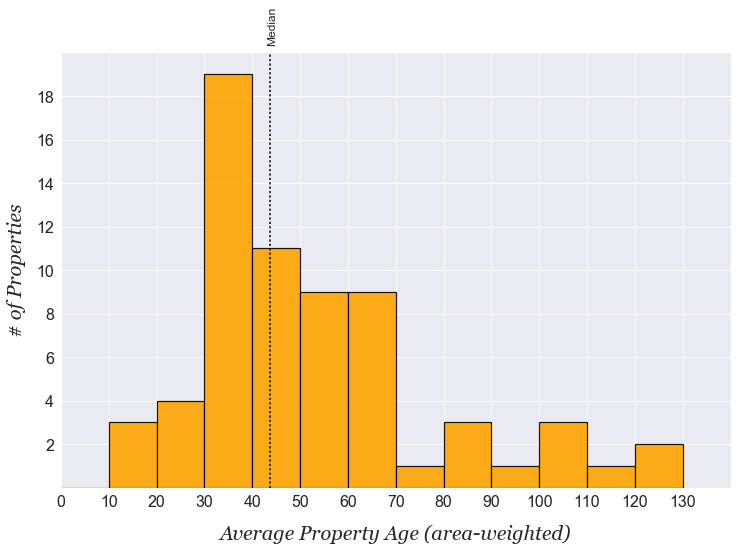

In [672]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(weighted.age, bins=range(0,140,10), norm_hist=False, kde=False, hist_kws={'alpha':0.9, 'color':'orange', 'edgecolor':'black', 'linewidth':1.2})
ax.set_xlabel('Average Property Age (area-weighted)', fontsize=20, labelpad=15, fontname='Georgia', style='italic')
ax.set_ylabel('# of Properties', fontsize=20, labelpad=10, fontname='Georgia', style='italic')
plt.yticks(range(2,20, 2))
plt.xticks(range(0,140,10))
ax.set_xlim(0, 140)
ax.set_ylim(0, 20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)
plt.axvline(x=weighted.age.median(), ymin=0, ymax=20, color='black', linestyle=':', linewidth=1.5)
plt.text(weighted.age.median()-0.5,21.75,'Median',rotation=90, fontsize=12)
fig.savefig('C:/Users/ddiaz/Desktop/PropertyAges.png')
plt.show()

## Making graphs of scenarios for all properties

In [164]:
parcel_id = [parcel for parcel in pd.unique(parcel_atts.parcel)]
rxs = ['FPA-SHORT', 'FSC-SHORT', 'FPA-LONG', 'FSC-LONG', 'GROW-ONLY']
years = [yr for yr in range(2014,2114,5)]
to_combine = [parcel_id, rxs, years]
graph_df = pd.DataFrame(list(itertools.product(*to_combine)), columns=['parcel', 'rx', 'year'])
graph_df['mrch_boardfoot_volume'] = np.nan
graph_df['allcarbon'] = np.nan
graph_df['pnv'] = np.nan
graph_df['rbdft'] = np.nan
graph_df['undiscounted_net'] = np.nan
graph_df = graph_df.set_index(['rx', 'parcel', 'year']).sort_index()

# for "leveling the playing field" scenarios where we hold buffers constant across scenarios
FPA_bufs = graph_df.copy()
FSC_bufs = graph_df.copy()

In [165]:
graph_df.head()

mrch_boardfoot_volume  allcarbon  pnv  rbdft  \
rx       parcel year                                                 
FPA-LONG 1      2014                    NaN        NaN  NaN    NaN   
                2019                    NaN        NaN  NaN    NaN   
                2024                    NaN        NaN  NaN    NaN   
                2029                    NaN        NaN  NaN    NaN   
                2034                    NaN        NaN  NaN    NaN   

                      undiscounted_net  
rx       parcel year                    
FPA-LONG 1      2014               NaN  
                2019               NaN  
                2024               NaN  
                2029               NaN  
                2034               NaN

In [24]:
parcels = parcel_atts.reset_index().set_index('standid')
fvs = parcels.join(FVSOut.set_index(['standid', 'year']))
fvs = fvs.reset_index().set_index(['parcel', 'mgmtid', 'standid', 'year']).sort_index()

In [72]:
fvs.head()

type   non_rip      core     inner  outer  \
parcel mgmtid standid year                                                
1      Rx1    1       2014  random  3.324138  0.239295  0.301665    0.0   
                      2019  random  3.324138  0.239295  0.301665    0.0   
                      2024  random  3.324138  0.239295  0.301665    0.0   
                      2029  random  3.324138  0.239295  0.301665    0.0   
                      2034  random  3.324138  0.239295  0.301665    0.0   

                            fsc_grow       fsc  total_acres  \
parcel mgmtid standid year                                    
1      Rx1    1       2014  1.035632  2.829467     3.865099   
                      2019  1.035632  2.829467     3.865099   
                      2024  1.035632  2.829467     3.865099   
                      2029  1.035632  2.829467     3.865099   
                      2034  1.035632  2.829467     3.865099   

                                                          caseid  age  \
parcel mgmtid standid year                                              
1      Rx1    1       2014  9b07ba82-ff28-4214-94a1-0bbe070007f1   42   
                      2019  9b07ba82-ff28-4214-94a1-0bbe070007f1   47   
                      2024  9b07ba82-ff28-4214-94a1-0bbe070007f1   52   
                      2029  9b07ba82-ff28-4214-94a1-0bbe070007f1   57   
                      2034  9b07ba82-ff28-4214-94a1-0bbe070007f1   62   

                                  ...         products  pnv  \
parcel mgmtid standid year        ...                         
1      Rx1    1       2014        ...              0.0  0.0   
                      2019        ...              0.0  0.0   
                      2024        ...              0.0  0.0   
                      2029        ...              0.0  0.0   
                      2034        ...              0.0  0.0   

                            undiscounted_cost  undiscounted_revenue  \
parcel mgmtid standid year                                            
1      Rx1    1       2014                0.0                   0.0   
                      2019                0.0                   0.0   
                      2024                0.0                   0.0   
                      2029                0.0                   0.0   
                      2034                0.0                   0.0   

                            discounted_cost  discounted_revenue  \
parcel mgmtid standid year                                        
1      Rx1    1       2014              0.0                 0.0   
                      2019              0.0                 0.0   
                      2024              0.0                 0.0   
                      2029              0.0                 0.0   
                      2034              0.0                 0.0   

                            mrch_cubic_volume  mrch_boardfoot_volume  \
parcel mgmtid standid year                                             
1      Rx1    1       2014                  0                      0   
                      2019                  0                      0   
                      2024                  0                      0   
                      2029                  0                      0   
                      2034                  0                      0   

                            allcarbon  undiscounted_net  
parcel mgmtid standid year                               
1      Rx1    1       2014    79.0222               0.0  
                      2019    89.9880               0.0  
                      2024   103.3510               0.0  
                      2029   117.6960               0.0  
                      2034   132.2770               0.0  

[5 rows x 46 columns]

### Expand per-acre outputs to property sizes using separate FPA and FSC buffers
This follows FPA buffers for FPA scenarios, and FSC buffers for FSC scenarios.

In [166]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)
    
# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# Add total_acres and % riparian cover
graph_df = graph_df.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

graph_df['cum_MBF_acre'] = graph_df.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / graph_df.total_acres
graph_df['tco2e_acre'] = graph_df.allcarbon *44/12 / graph_df.total_acres
graph_df['npv_acre'] = graph_df.pnv / graph_df.total_acres
graph_df['undisc_net_acre'] = graph_df.undiscounted_net / graph_df.total_acres
graph_df['cum_rMBF_acre'] = graph_df.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / graph_df.total_acres
graph_df['pct_fscgrow'] = graph_df.fsc_grow / graph_df.total_acres


# add state_names for each parcel, append state_name to multi-level index of dataframe
graph_df = graph_df.join(parcel_states.state_name)
graph_df = graph_df.set_index('state_name', append=True)

# take a peek
graph_df.head()

mrch_boardfoot_volume     allcarbon  \
rx       parcel year state_name                                        
FPA-LONG 1      2014 OR                   8.445453e+05  51938.563568   
                2019 OR                   1.792735e+06  55786.078470   
                2024 OR                   0.000000e+00  61620.033331   
                2029 OR                   4.838843e+06  63311.372514   
                2034 OR                   5.184368e+05  67339.285615   

                                          pnv         rbdft  undiscounted_net  \
rx       parcel year state_name                                                 
FPA-LONG 1      2014 OR          2.738282e+05  8.678789e+05      2.981511e+05   
                2019 OR          7.503053e+05  1.811348e+06      9.588646e+05   
                2024 OR          7.503053e+05  0.000000e+00      9.588646e+05   
                2029 OR          1.505491e+06  4.936746e+06      2.668400e+06   
                2034 OR          1.566921e+06  5.398606e+05      2.846536e+06   

                                 total_acres    fsc_grow  cum_MBF_acre  \
rx       parcel year state_name                                          
FPA-LONG 1      2014 OR           591.089459  181.835923      1.428794   
                2019 OR           591.089459  181.835923      4.461728   
                2024 OR           591.089459  181.835923      4.461728   
                2029 OR           591.089459  181.835923     12.648041   
                2034 OR           591.089459  181.835923     13.525128   

                                 tco2e_acre     npv_acre  undisc_net_acre  \
rx       parcel year state_name                                             
FPA-LONG 1      2014 OR          322.187102   463.260215       504.409381   
                2019 OR          346.054140  1269.360009      1622.198834   
                2024 OR          382.243532  1269.360009      1622.198834   
                2029 OR          392.735306  2546.976985      4514.375514   
                2034 OR          417.721396  2650.903126      4815.743999   

                                 cum_rMBF_acre  pct_fscgrow  
rx       parcel year state_name                              
FPA-LONG 1      2014 OR               1.468270     0.307628  
                2019 OR               4.532694     0.307628  
                2024 OR               4.532694     0.307628  
                2029 OR              12.884638     0.307628  
                2034 OR              13.797969     0.307628

### Graph attributes over time (hurricane-style graphs)

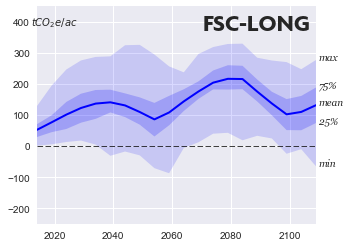

In [167]:
fig, ax = plt.subplots(1, figsize=(5,4))
attribute = 'tco2e_acre'
scenario = 'FSC-LONG'
base_scenario = 'FPA-SHORT'
baseline = graph_df.xs(base_scenario, level=0)
diff = graph_df.xs(scenario, level=0) - baseline
diff = diff.reset_index()
years = np.array(pd.unique(diff.year))
mean = diff.groupby('year').mean()[attribute]
pct25 = diff.groupby('year').quantile(.25)[attribute]
pct75 = diff.groupby('year').quantile(.75)[attribute]
minimum = diff.groupby('year').min()[attribute]
maximum = diff.groupby('year').max()[attribute]

ax.plot(years,mean , lw=2, color='blue')
ax.fill_between(years, pct25, pct75, facecolor='blue', alpha=0.20)
ax.fill_between(years, minimum, maximum, facecolor='blue', alpha=0.15)

#ax = sns.tsplot(data=rx4, time='year', unit='parcel', value='tco2e_acre', err_style='unit_traces')
#ax = sns.tsplot(data=rx4, time='year', unit='parcel', value='tco2e_acre', err_style='range_band', n_boot=0)
ax.set_ylim(-250, 450)
ax.set_xlim(years.min(), years.max())
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.75)
ax.text(x=years.min()-2, y=400, s='$tCO_2e/ac$', fontsize=10, fontname='Georgia', verticalalignment='center', style='italic')
ax.text(x=2107, y=390, s=scenario, fontsize=24, fontname='Agenda', weight='semibold', horizontalalignment='right', verticalalignment='center')
ax.text(x=years[-1]+1, y=minimum.iloc[-1], s='min', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=pct25.iloc[-1], s='25%', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=pct75.iloc[-1], s='75%', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=maximum.iloc[-1], s='max', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=mean.iloc[-1], s='mean', fontname='Georgia', style='italic', fontsize=10)
plt.show()

### Scatter plot of attributes at end of simulation

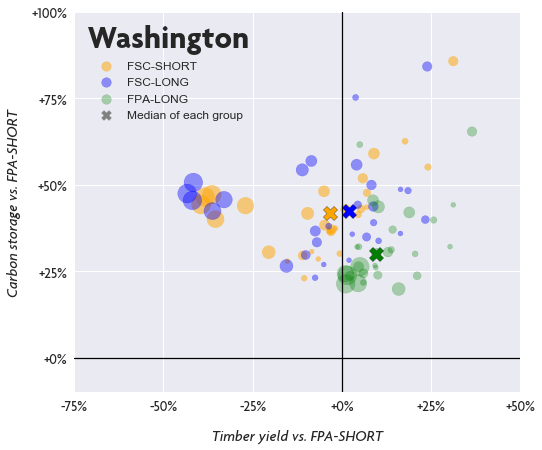

In [181]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, figsize=(8,7))
state = 'WA'
fullname = 'Washington' if state == 'WA' else 'Oregon'
temp_df = graph_df.loc[graph_df.index.get_level_values(3) == state]
BAU_cumMBF = temp_df.loc['FPA-SHORT'].xs(2109, level=(1)).cum_MBF_acre
BAU_avgC = temp_df.loc['FPA-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_cumMBF = temp_df.loc['FSC-SHORT'].xs(2109, level=(1)).cum_MBF_acre
fsc_short_avgC = temp_df.loc['FSC-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_long_cumMBF = temp_df.loc['FSC-LONG'].xs(2109, level=(1)).cum_MBF_acre
fsc_long_avgC = temp_df.loc['FSC-LONG'].tco2e_acre.groupby(level='parcel').mean()
fpa_long_cumMBF = temp_df.loc['FPA-LONG'].xs(2109, level=(1)).cum_MBF_acre
fpa_long_avgC = temp_df.loc['FPA-LONG'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_x = (fsc_short_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fsc_short_y = (fsc_short_avgC - BAU_avgC)/BAU_avgC * 100
fsc_long_x = (fsc_long_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fsc_long_y = (fsc_long_avgC - BAU_avgC)/BAU_avgC * 100
fpa_long_x = (fpa_long_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fpa_long_y = (fpa_long_avgC - BAU_avgC)/BAU_avgC * 100
marker_size = temp_df.pct_fscgrow.groupby('parcel').mean()

# Scatter of carbon and timber for all properties
ax.scatter(fsc_short_x, fsc_short_y, color='orange', alpha=0.5, s=25+marker_size*900, label='FSC-SHORT')
ax.scatter(fsc_long_x, fsc_long_y, color='blue', alpha=0.4, s=25+marker_size*900, label='FSC-LONG')

# FPA-LONG scenario
ax.scatter(fpa_long_x, fpa_long_y, color='green', alpha=0.3, s=25+marker_size*900, label='FPA-LONG')
ax.scatter(fpa_long_x.median(), fpa_long_y.median(), color='green', marker='X', s=200, edgecolor='black')

# Medians of all properties
ax.scatter(fsc_short_x.median(), fsc_short_y.median(), color='orange', marker='X', s=200, edgecolor='black')
ax.scatter(fsc_long_x.median(), fsc_long_y.median(), color='blue', marker='X', s=200, edgecolor='black')
# for legend
ax.scatter(-10000, -10000, color='gray', marker='X', s=200, edgecolor='gray', label='Median of each group')


# Styling
ax.axhline(y=0, color='black', linewidth=1.25)
ax.axvline(x=0, color='black', linewidth=1.25)
ax.set_ylim(-10, 100)
ax.set_xlim(-75, 50)
ax.set_ylabel('Carbon storage vs. FPA-SHORT', labelpad=10, fontsize=15, fontname='Agenda', style='italic')
ax.set_xlabel('Timber yield vs. FPA-SHORT', labelpad=15, fontsize=15, fontname='Agenda', style='italic')

plt.yticks([x for x in range(0,125,25)], fontsize=14, fontname='Agenda', weight='book')
plt.xticks([x for x in range(-75,75,25)], fontsize=14, fontname='Agenda', weight='book')
ax.text(x=-71, y=92, s=fullname, fontsize=32, fontname='Agenda', weight='semibold', horizontalalignment='left', verticalalignment='center')
tick = ticker.StrMethodFormatter('{x:+}%')
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
plt.legend(loc='upper left', bbox_to_anchor=(0.02,0.90), fontsize=12, markerscale=0.7)
plt.savefig('C:/Users/ddiaz/Desktop/FSCscatter_OR_wFPAlong.png')
plt.show()

### Expand per-acre outputs to property sizes using FPA buffers
This follows FPA buffers for all scenarios (both FPA and FSC).

In [169]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
#     fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
#     fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# Add total_acres and % riparian cover
FPA_bufs = FPA_bufs.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

FPA_bufs['cum_MBF_acre'] = FPA_bufs.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FPA_bufs.total_acres
FPA_bufs['tco2e_acre'] = FPA_bufs.allcarbon *44/12 / FPA_bufs.total_acres
FPA_bufs['npv_acre'] = FPA_bufs.pnv / FPA_bufs.total_acres
FPA_bufs['undisc_net_acre'] = FPA_bufs.undiscounted_net / FPA_bufs.total_acres
FPA_bufs['cum_rMBF_acre'] = FPA_bufs.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FPA_bufs.total_acres
FPA_bufs['pct_fscgrow'] = FPA_bufs.fsc_grow / FPA_bufs.total_acres

# add state_names for each parcel, append state_name to multi-level index of dataframe
FPA_bufs = FPA_bufs.join(parcel_states.state_name)
FPA_bufs = FPA_bufs.set_index('state_name', append=True)

# take a peek
FPA_bufs.head()

mrch_boardfoot_volume     allcarbon  \
rx       parcel year state_name                                        
FPA-LONG 1      2014 OR                   8.445453e+05  51938.563568   
                2019 OR                   1.792735e+06  55786.078470   
                2024 OR                   0.000000e+00  61620.033331   
                2029 OR                   4.838843e+06  63311.372514   
                2034 OR                   5.184368e+05  67339.285615   

                                          pnv         rbdft  undiscounted_net  \
rx       parcel year state_name                                                 
FPA-LONG 1      2014 OR          2.738282e+05  8.678789e+05      2.981511e+05   
                2019 OR          7.503053e+05  1.811348e+06      9.588646e+05   
                2024 OR          7.503053e+05  0.000000e+00      9.588646e+05   
                2029 OR          1.505491e+06  4.936746e+06      2.668400e+06   
                2034 OR          1.566921e+06  5.398606e+05      2.846536e+06   

                                 total_acres    fsc_grow  cum_MBF_acre  \
rx       parcel year state_name                                          
FPA-LONG 1      2014 OR           591.089459  181.835923      1.428794   
                2019 OR           591.089459  181.835923      4.461728   
                2024 OR           591.089459  181.835923      4.461728   
                2029 OR           591.089459  181.835923     12.648041   
                2034 OR           591.089459  181.835923     13.525128   

                                 tco2e_acre     npv_acre  undisc_net_acre  \
rx       parcel year state_name                                             
FPA-LONG 1      2014 OR          322.187102   463.260215       504.409381   
                2019 OR          346.054140  1269.360009      1622.198834   
                2024 OR          382.243532  1269.360009      1622.198834   
                2029 OR          392.735306  2546.976985      4514.375514   
                2034 OR          417.721396  2650.903126      4815.743999   

                                 cum_rMBF_acre  pct_fscgrow  
rx       parcel year state_name                              
FPA-LONG 1      2014 OR               1.468270     0.307628  
                2019 OR               4.532694     0.307628  
                2024 OR               4.532694     0.307628  
                2029 OR              12.884638     0.307628  
                2034 OR              13.797969     0.307628

### Estimate the relative change in attributes when all scenarios use FPA buffers.

In [170]:
new_base_scenario = 'FPA-SHORT'
compare_scenario = 'FSC-SHORT'
new_baseline = FPA_bufs.xs(new_base_scenario, level=0)
new_scenario = FPA_bufs.xs(compare_scenario, level=0)
new_diff = (new_scenario - new_baseline)/new_baseline

# use the final year's cumulative value of npv, timber yield to identify median change for parcels vs. FPA-SHORT
print(compare_scenario, 'with FPA buffers')
print(new_diff[['cum_MBF_acre', 'npv_acre']].xs(new_diff.index.get_level_values(1).max(), level=1, drop_level=False).groupby(level=2).median())
# use the average over all years of scenarios to get median change in carbon storage
print(compare_scenario, 'FPA buffers')
print(new_diff['tco2e_acre'].groupby(level=[0,2]).mean().groupby(level=1).median())

FSC-SHORT with FPA buffers
            cum_MBF_acre  npv_acre
state_name                        
OR             -0.069869 -0.209418
WA              0.012476 -0.181087
FSC-SHORT FPA buffers
state_name
OR    0.249261
WA    0.318252
Name: tco2e_acre, dtype: float64


### Expand per-acre outputs to property sizes using FSC buffers
This follows FSC buffers for all scenarios (both FPA and FSC).

In [171]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
#     core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
#     core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)
    
# Add total_acres and % riparian cover
FSC_bufs = FSC_bufs.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

FSC_bufs['cum_MBF_acre'] = FSC_bufs.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FSC_bufs.total_acres
FSC_bufs['tco2e_acre'] = FSC_bufs.allcarbon *44/12 / FSC_bufs.total_acres
FSC_bufs['npv_acre'] = FSC_bufs.pnv / FSC_bufs.total_acres
FSC_bufs['undisc_net_acre'] = FSC_bufs.undiscounted_net / FSC_bufs.total_acres
FSC_bufs['cum_rMBF_acre'] = FSC_bufs.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FSC_bufs.total_acres
FSC_bufs['pct_fscgrow'] = FSC_bufs.fsc_grow / FSC_bufs.total_acres

# add state_names for each parcel, append state_name to multi-level index of dataframe
FSC_bufs = FSC_bufs.join(parcel_states.state_name)
FSC_bufs = FSC_bufs.set_index('state_name', append=True)

# take a peek
FSC_bufs.head()

mrch_boardfoot_volume     allcarbon  \
rx       parcel year state_name                                        
FPA-LONG 1      2014 OR                   7.857407e+05  52016.404152   
                2019 OR                   1.458366e+06  56142.300409   
                2024 OR                   0.000000e+00  62169.579513   
                2029 OR                   3.839026e+06  65215.649678   
                2034 OR                   4.196518e+05  70124.113563   

                                          pnv         rbdft  undiscounted_net  \
rx       parcel year state_name                                                 
FPA-LONG 1      2014 OR          2.555051e+05  8.072858e+05      2.781696e+05   
                2019 OR          6.431215e+05  1.473529e+06      8.156631e+05   
                2024 OR          6.431215e+05  0.000000e+00      8.156631e+05   
                2029 OR          1.243546e+06  3.912621e+06      2.174655e+06   
                2034 OR          1.293779e+06  4.370166e+05      2.320265e+06   

                                 total_acres    fsc_grow  cum_MBF_acre  \
rx       parcel year state_name                                          
FPA-LONG 1      2014 OR           591.089459  181.835923      1.329309   
                2019 OR           591.089459  181.835923      3.796561   
                2024 OR           591.089459  181.835923      3.796561   
                2029 OR           591.089459  181.835923     10.291391   
                2034 OR           591.089459  181.835923     11.001354   

                                 tco2e_acre     npv_acre  undisc_net_acre  \
rx       parcel year state_name                                             
FPA-LONG 1      2014 OR          322.669965   432.261370       470.604883   
                2019 OR          348.263868  1088.027315      1379.931785   
                2024 OR          385.652495  1088.027315      1379.931785   
                2029 OR          404.547984  2103.820388      3679.062292   
                2034 OR          434.996337  2188.803496      3925.403412   

                                 cum_rMBF_acre  pct_fscgrow  
rx       parcel year state_name                              
FPA-LONG 1      2014 OR               1.365759     0.307628  
                2019 OR               3.858663     0.307628  
                2024 OR               3.858663     0.307628  
                2029 OR              10.478001     0.307628  
                2034 OR              11.217342     0.307628

In [172]:
new_base_scenario = 'FPA-SHORT'
compare_scenario = 'FPA-LONG'
new_baseline = FPA_bufs.xs(new_base_scenario, level=0)
new_scenario = FPA_bufs.xs(compare_scenario, level=0)
new_diff = (new_scenario - new_baseline)/new_baseline

# use the final year's cumulative value of npv, timber yield to identify median change for parcels vs. FPA-SHORT
print(compare_scenario, 'with FSC buffers' )
print(new_diff[['cum_MBF_acre', 'npv_acre']].xs(new_diff.index.get_level_values(1).max(), level=1, drop_level=False).groupby(level=2).median())
# use the average over all years of scenarios to get median change in carbon storage
print(compare_scenario, 'FPA buffers')
print(new_diff['tco2e_acre'].groupby(level=[0,2]).mean().groupby(level=1).median())

FPA-LONG with FSC buffers
            cum_MBF_acre  npv_acre
state_name                        
OR              0.065394 -0.210795
WA              0.094828 -0.164614
FPA-LONG FPA buffers
state_name
OR    0.302630
WA    0.306355
Name: tco2e_acre, dtype: float64


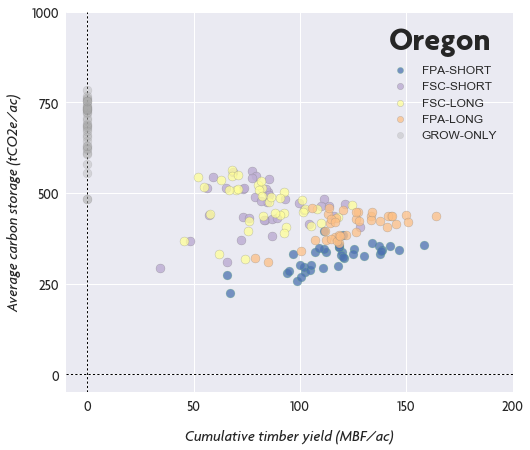

In [385]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, figsize=(8,7))
state = 'OR'
fullname = 'Washington' if state == 'WA' else 'Oregon'
temp_df = graph_df.loc[graph_df.index.get_level_values(3) == state]
BAU_cumMBF = temp_df.loc['FPA-SHORT'].xs(2109, level=(1)).cum_MBF_acre
BAU_avgC = temp_df.loc['FPA-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_cumMBF = temp_df.loc['FSC-SHORT'].xs(2109, level=(1)).cum_MBF_acre
fsc_short_avgC = temp_df.loc['FSC-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_long_cumMBF = temp_df.loc['FSC-LONG'].xs(2109, level=(1)).cum_MBF_acre
fsc_long_avgC = temp_df.loc['FSC-LONG'].tco2e_acre.groupby(level='parcel').mean()
fpa_long_cumMBF = temp_df.loc['FPA-LONG'].xs(2109, level=(1)).cum_MBF_acre
fpa_long_avgC = temp_df.loc['FPA-LONG'].tco2e_acre.groupby(level='parcel').mean()
grow_only_cumMBF = temp_df.loc['GROW-ONLY'].xs(2109, level=(1)).cum_MBF_acre
grow_only_avgC = temp_df.loc['GROW-ONLY'].tco2e_acre.groupby(level='parcel').mean()
# fsc_short_x = fsc_short_cumMBF
# fsc_short_y = fsc_short_avgC
# fsc_long_x = fsc_long_cumMBF
# fsc_long_y = fsc_long_avgC
# fpa_long_x = fpa_long_cumMBF
# fpa_long_y = fpa_long_avgC
# grow_only_x = grow_only_cumMBF
# grow_only_y = grow_only_avgC
marker_size = temp_df.pct_fscgrow.groupby('parcel').mean()

# Scatter of carbon and timber for all properties
ax.scatter(BAU_cumMBF, BAU_avgC, edgecolor='#7fc97f', alpha=0.75, s=80, label='FPA-SHORT')
ax.scatter(fsc_short_cumMBF, fsc_short_avgC, color='#beaed4', alpha=0.85, edgecolor='gray', s=80, label='FSC-SHORT')
ax.scatter(fsc_long_cumMBF, fsc_long_avgC, color='#ffff99', alpha=0.75, edgecolor='gray', s=80, label='FSC-LONG')
ax.scatter(fpa_long_cumMBF, fpa_long_avgC, color='#fdc086', alpha=0.75, edgecolor='gray', s=80, label='FPA-LONG')
ax.scatter(grow_only_cumMBF, grow_only_avgC, color='darkgray', alpha=0.35, edgecolor='gray', s=80, label='GROW-ONLY', zorder=2)


# Medians of all properties
# ax.scatter(BAU_cumMBF.median(), BAU_avgC.median(), color='#7fc97f', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fsc_long_cumMBF.median(), fsc_long_avgC.median(), color='#beaed4', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fsc_short_cumMBF.median(), fsc_short_avgC.median(), color='#ffff99', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fpa_long_cumMBF.median(), fpa_long_avgC.median(), color='#fdc086', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(grow_only_cumMBF.median(), grow_only_avgC.median(), color='darkgray', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(-10000, -10000, color='gray', marker='X', s=100, edgecolor='gray', label='Median of each group') # for legend

# Styling
ax.axhline(y=0, color='black', linewidth=1, linestyle=':', zorder=1)
ax.axvline(x=0, color='black', linewidth=1, linestyle=':', zorder=1)
ax.set_ylim(-50, 1000)
ax.set_xlim(-10, 200)
ax.set_ylabel('Average carbon storage (tCO2e/ac)', labelpad=10, fontsize=15, fontname='Agenda', style='italic')
ax.set_xlabel('Cumulative timber yield (MBF/ac)', labelpad=15, fontsize=15, fontname='Agenda', style='italic')

plt.yticks([x for x in range(0,1001,250)], fontsize=14, fontname='Agenda', weight='book')
plt.xticks([x for x in range(0,201,50)], fontsize=14, fontname='Agenda', weight='book')
ax.text(x=190, y=920, s=fullname, fontsize=32, fontname='Agenda', weight='semibold', horizontalalignment='right', verticalalignment='center')
#tick = ticker.StrMethodFormatter('{x:+}')
#ax.xaxis.set_major_formatter(tick)
#ax.yaxis.set_major_formatter(tick)
plt.legend(loc='upper right', bbox_to_anchor=(0.99,0.89), fontsize=12, markerscale=0.7)
plt.savefig('C:/Users/ddiaz/Desktop/FSCscatter_WA-allscenarios.png')
plt.show()